In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pickle


In [2]:
import pyodbc

In [3]:
conn = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=DESKTOP-7K1D2RJ;"  # Change server name if needed
    "Database=DWH;"
    "Trusted_Connection=yes;"
)

In [4]:
query = "SELECT * FROM Dim_Facture"
df = pd.read_sql(query, conn)

C:\Users\Ichrak\AppData\Local\Temp\ipykernel_16940\2040495026.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [113]:
query = """
SELECT 
    f.InvoiceID,
    f.Quantity,
    f.TotalPrice,
    f.UnitPrice,
    p.ProductName,
    p.Category
FROM 
    Dim_Facture f
JOIN 
    Dim_Product p ON f.ProductID = p.ProductID
"""

# Fetch the data into a DataFrame
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Display the data
print(df.head())

  InvoiceID  Quantity  TotalPrice  UnitPrice      ProductName      Category
0  INV00845         7      610.26      87.18  Bouteille d'eau   Alimentaire
1  INV05830         8      719.44      89.93             Pain       Boisson
2  INV05446         6      107.82      17.97        Confiture       Textile
3  INV00264         3      116.13      38.71           Poulet   Alimentaire
4  INV03016         5      128.60      25.72            Pâtes  Electronique


C:\Users\fayed\AppData\Local\Temp\ipykernel_888\107323630.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [114]:
# Condition métier claire avec AND logique
def classifier_facture(row):
    if row['UnitPrice'] > 10 and row['Quantity'] > 2 and row['TotalPrice'] > 10:
        return 1  # facture suspecte
    return 0  # facture normale

# Applique la règle
df['Label'] = df.apply(classifier_facture, axis=1)

# Vérification des premières lignes
print(df[['InvoiceID', 'Quantity', 'TotalPrice', 'ProductName', 'Category', 'Label']].head(100))


   InvoiceID  Quantity  TotalPrice      ProductName      Category  Label
0   INV00845         7      610.26  Bouteille d'eau   Alimentaire      1
1   INV05830         8      719.44             Pain       Boisson      1
2   INV05446         6      107.82        Confiture       Textile      1
3   INV00264         3      116.13           Poulet   Alimentaire      1
4   INV03016         5      128.60            Pâtes  Electronique      1
..       ...       ...         ...              ...           ...    ...
95  INV03292         8      380.80            Pâtes  Electronique      1
96  INV00387         6      140.94         Chocolat  Electronique      1
97  INV03598         9       29.79  Pommes de terre       Boisson      0
98  INV05447         1       13.58          Légumes  Electronique      0
99  INV06735         7      206.01          Fromage  Electronique      1

[100 rows x 6 columns]


In [115]:
df.columns

Index(['InvoiceID', 'Quantity', 'TotalPrice', 'UnitPrice', 'ProductName',
       'Category', 'Label'],
      dtype='object')

In [116]:
# Calculate the total number of rows in the DataFrame
total_rows = df.shape[0]

# Calculate the number of missing values (NaN) for each feature
missing_values = df.isnull().sum()

# Calculate the percentage of missing values for each feature
percentage_missing = (missing_values / total_rows) * 100

# Create a DataFrame to store the results
missing_data_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage': percentage_missing})

# Display the DataFrame
print(missing_data_info)

             Missing Values  Percentage
InvoiceID                 0         0.0
Quantity                  0         0.0
TotalPrice                0         0.0
UnitPrice                 0         0.0
ProductName               0         0.0
Category                  0         0.0
Label                     0         0.0


In [117]:
relevant_features = ['Quantity', 'TotalPrice', 'ProductName', 'Category', 'Label']

# Create a new DataFrame with only the relevant features
df_relevant = df[relevant_features].copy()

# Display the first few rows of the new DataFrame
print(df_relevant.shape)


(7203, 5)


In [118]:
df_relevant

,Quantity,TotalPrice,ProductName,Category,Label
0,7,610.26,Bouteille d'eau,Alimentaire,1
1,8,719.44,Pain,Boisson,1
2,6,107.82,Confiture,Textile,1
3,3,116.13,Poulet,Alimentaire,1
4,5,128.60,Pâtes,Electronique,1
...,...,...,...,...,...
7198,9,923.40,Kombucha Lökki Nature,Boissons,1
7199,11,1147.30,Kombucha Lökki Gingembre,Boissons,1
7200,13,1378.00,Kombucha Lökki Citron,Boissons,1
7201,7,707.70,Kombucha Lökki Pomme,Boissons,1


In [119]:
# Calculate the number of missing values for each feature
missing_values_per_feature = df_relevant.isnull().sum()

# Display the missing values for each feature
print("Missing Values per Feature:")
print(missing_values_per_feature)

Missing Values per Feature:
Quantity       0
TotalPrice     0
ProductName    0
Category       0
Label          0
dtype: int64


In [120]:
from sklearn.preprocessing import LabelEncoder
# Identify categorical columns
categorical_columns = df_relevant.select_dtypes(include=['object']).columns

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    df_relevant[col] = label_encoder.fit_transform(df_relevant[col])

df_relevant

,Quantity,TotalPrice,ProductName,Category,Label
0,7,610.26,16,0,1
1,8,719.44,86,1,1
2,6,107.82,33,28,1
3,3,116.13,106,0,1
4,5,128.60,114,10,1
...,...,...,...,...,...
7198,9,923.40,67,2,1
7199,11,1147.30,66,2,1
7200,13,1378.00,65,2,1
7201,7,707.70,68,2,1


In [121]:
# Calculate the total number of rows in the DataFrame
total_rows = df.shape[0]

# Calculate the number of missing values (NaN) for each feature
missing_values = df.isnull().sum()

# Calculate the percentage of missing values for each feature
percentage_missing = (missing_values / total_rows) * 100

# Create a DataFrame to store the results
missing_data_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage': percentage_missing})

# Display the DataFrame
print(missing_data_info)

             Missing Values  Percentage
InvoiceID                 0         0.0
Quantity                  0         0.0
TotalPrice                0         0.0
UnitPrice                 0         0.0
ProductName               0         0.0
Category                  0         0.0
Label                     0         0.0


In [122]:
df = df_relevant

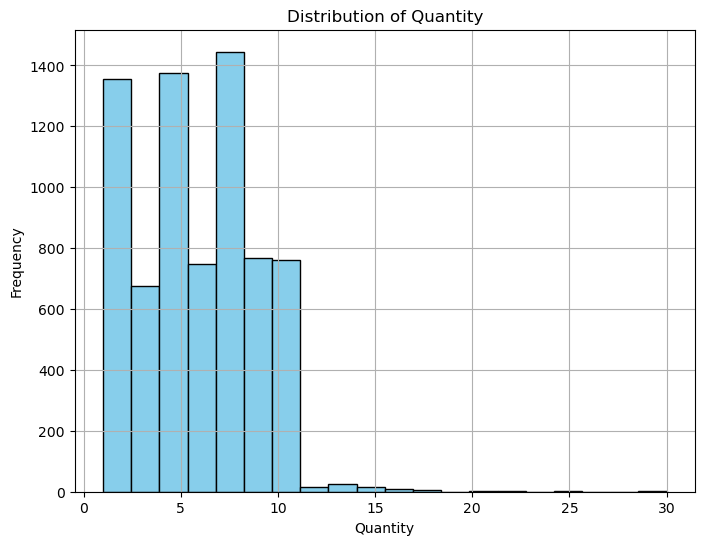

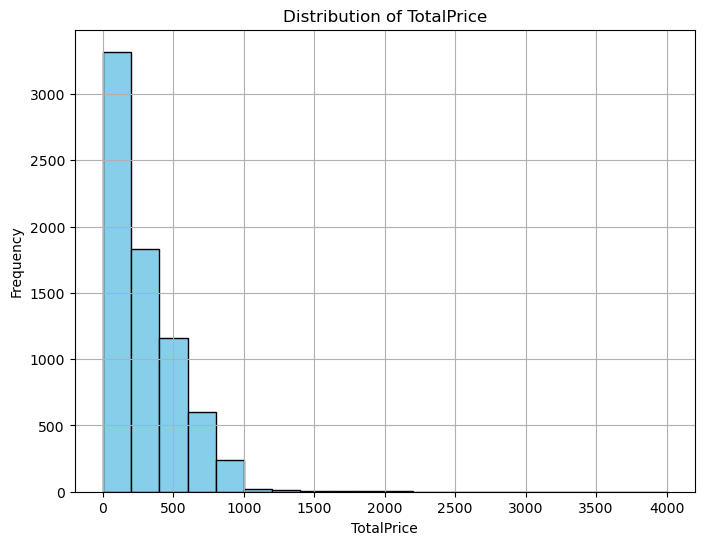

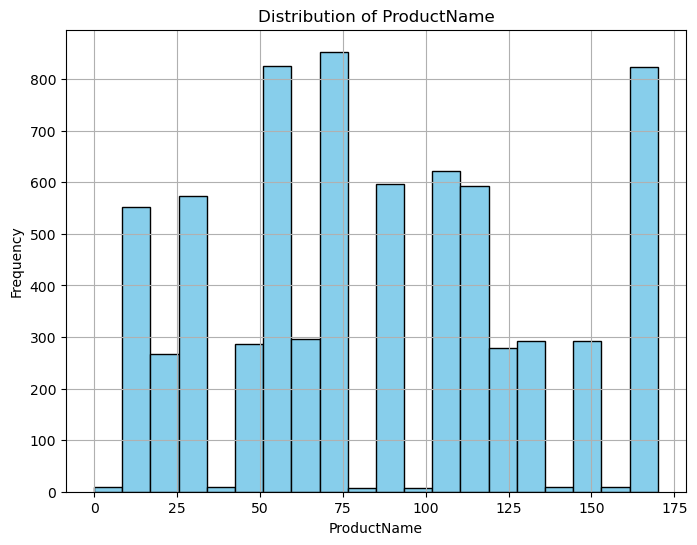

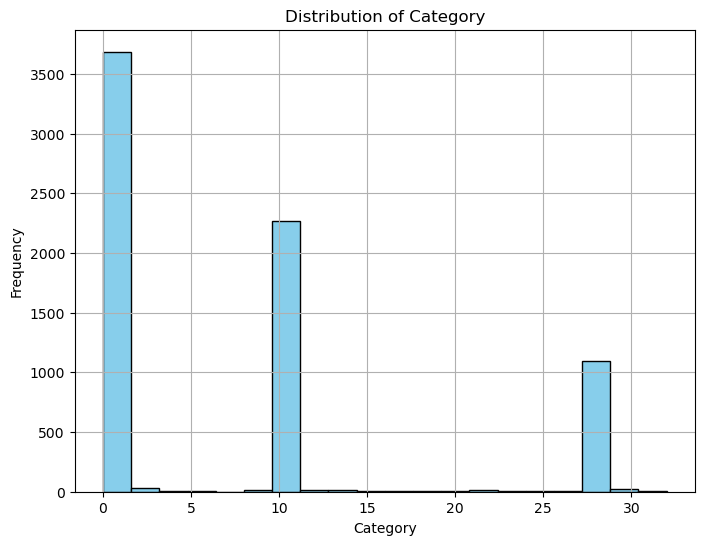

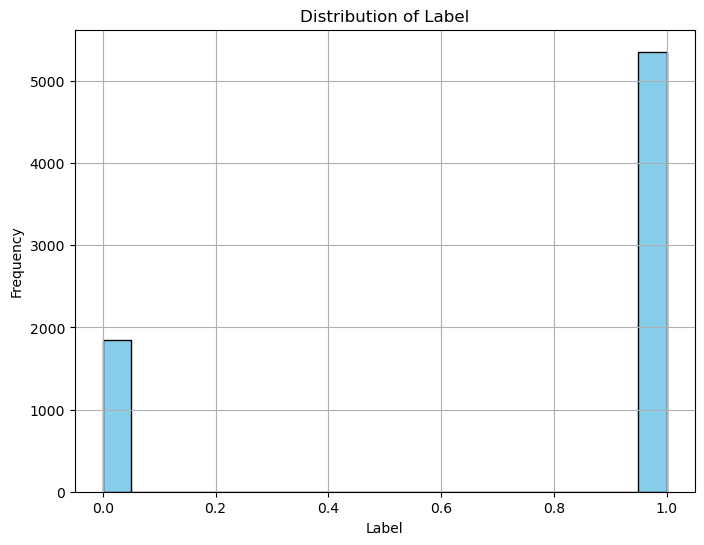

In [123]:
import matplotlib.pyplot as plt

def plot_distribution(df, feature_name):
    plt.figure(figsize=(8, 6))
    plt.hist(df[feature_name], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Loop through the first 12 columns of the DataFrame
for column in df.columns[:]:
    plot_distribution(df, column)

In [125]:
df

,Quantity,TotalPrice,ProductName,Category,Label
0,7,610.26,16,0,1
1,8,719.44,86,1,1
2,6,107.82,33,28,1
3,3,116.13,106,0,1
4,5,128.60,114,10,1
...,...,...,...,...,...
7198,9,923.40,67,2,1
7199,11,1147.30,66,2,1
7200,13,1378.00,65,2,1
7201,7,707.70,68,2,1


In [143]:
import pandas as pd

# Supposons les valeurs suivantes pour tester :
# Quantity = 10
# TotalPrice = 45
# Product_encoded = 3
# Category_encoded = 2

new_data = pd.DataFrame([{
    'Quantity': 10,
    'TotalPrice': 45,
    'ProductName': 3,
    'Category': 2
}])


In [144]:
new_sprediction_rf = logreg.predict(new_data)

In [145]:
print("Predicted :", new_sprediction_rf)

Predicted : [0]


In [146]:
##### 0 w lo5ra mch nrml 

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Séparer les variables explicatives (X) et la cible (y)
X = df.drop(columns=['Label'])
y = df['Label']

# Encodage des variables catégorielles si nécessaire
X = pd.get_dummies(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entraîner Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Prédictions
y_pred = gb_model.predict(X_test)

# Évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9979181124219292

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       349
           1       1.00      1.00      1.00      1092

    accuracy                           1.00      1441
   macro avg       1.00      1.00      1.00      1441
weighted avg       1.00      1.00      1.00      1441


Confusion Matrix:
 [[ 348    1]
 [   2 1090]]


In [132]:
new_data = pd.DataFrame([{
    'Quantity': 10,
    'TotalPrice': 45,
    'ProductName': 3,
    'Category': 2
}])

In [134]:
new_sprediction_rf = gb_model.predict(new_data)

In [135]:
print("Predicted :", new_sprediction_rf)

Predicted : [0]
